# Library

In [34]:
import pandas as pd
import numpy as np



In [81]:
! pip install pytorch-lightning

In [82]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torch

from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import SMAPE, MultivariateNormalDistributionLoss
import numpy as np

TypeError: Descriptors cannot not be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

# Data

In [73]:
def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]


In [58]:
data = pd.read_csv('../dataset/upbit_ohlcv_1700.csv')

In [59]:
data.head()

,index,open,high,low,close,volume,value
0,2017-09-29 09:00:00+09:00,4586000.0,4709000.0,4476000.0,4657000.0,59.352373,2.724558e+08
1,2017-09-30 09:00:00+09:00,4657000.0,4896000.0,4651000.0,4895000.0,19.998483,9.561476e+07
2,2017-10-01 09:00:00+09:00,4889000.0,4978000.0,4682000.0,4962000.0,27.323332,1.331325e+08
3,2017-10-02 09:00:00+09:00,4962000.0,5095000.0,4956000.0,5025000.0,31.728004,1.599315e+08
4,2017-10-03 09:00:00+09:00,5021000.0,5079000.0,4811000.0,4964000.0,11.899307,5.890130e+07


<AxesSubplot:>

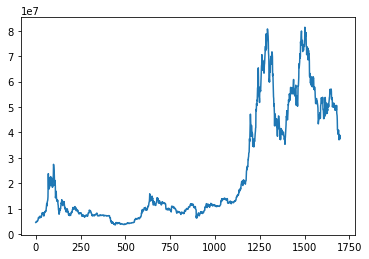

In [60]:
data['open'].plot()

<AxesSubplot:>

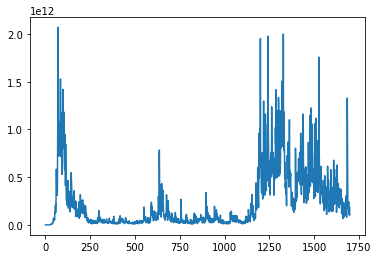

In [61]:
data['value'].plot()

In [62]:
ts.head()

0    4586000.0
1    4657000.0
2    4889000.0
3    4962000.0
4    5021000.0
Name: open, dtype: float64

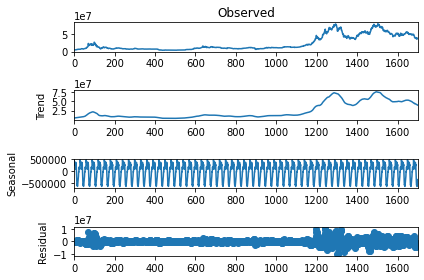

In [63]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(ts.values, model='additive', period=30, extrapolate_trend='freq').plot()

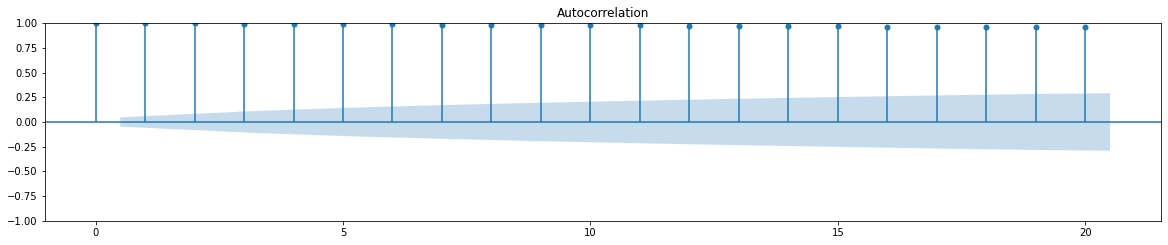

In [64]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts, lags=20, ax=ax)


In [65]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(ts)
print(f'adf statistics: {result[0]}')
print(f'p-value: {result[1]}')


adf statistics: -1.375655164610864
p-value: 0.5938901032077417


In [66]:
# 차분 

def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]

ts_diff1 = difference(ts, 1)

In [67]:
result = adfuller(np.array(ts_diff1))
print(f'adf statistics: {result[0]}')
print(f'p-value: {result[1]}')


adf statistics: -15.816147905498013
p-value: 1.032975894720297e-28


c:\Users\82108\anaconda3\envs\tobigs\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


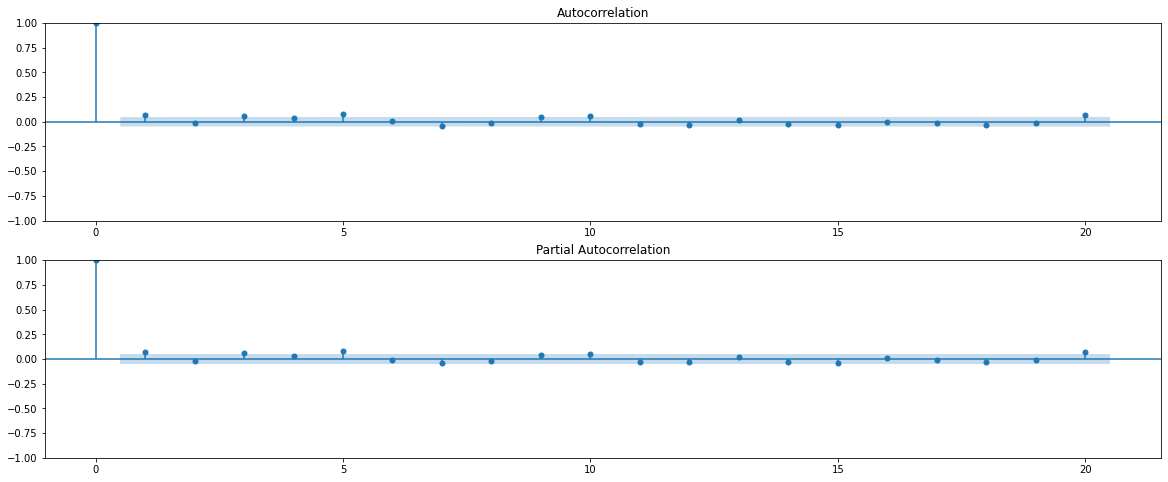

In [68]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_diff1, lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_diff1, lags=20, ax=ax2)

In [70]:
ts.head()

0    4586000.0
1    4657000.0
2    4889000.0
3    4962000.0
4    5021000.0
Name: open, dtype: float64

In [72]:
data.head()

,index,open,high,low,close,volume,value
0,2017-09-29 09:00:00+09:00,4586000.0,4709000.0,4476000.0,4657000.0,59.352373,2.724558e+08
1,2017-09-30 09:00:00+09:00,4657000.0,4896000.0,4651000.0,4895000.0,19.998483,9.561476e+07
2,2017-10-01 09:00:00+09:00,4889000.0,4978000.0,4682000.0,4962000.0,27.323332,1.331325e+08
3,2017-10-02 09:00:00+09:00,4962000.0,5095000.0,4956000.0,5025000.0,31.728004,1.599315e+08
4,2017-10-03 09:00:00+09:00,5021000.0,5079000.0,4811000.0,4964000.0,11.899307,5.890130e+07


In [74]:
ts_selected = data['open']
ts_diff = pd.Series(difference(ts_selected, 1))

#-- train validation split 
train_size = int((len(ts_diff)-output_window) * train_rate)
valid_size = (len(ts_diff)-output_window)- train_size
train_data = np.array(ts_diff.iloc[:train_size]).reshape(-1,1)
valid_data = np.array(ts_diff.iloc[train_size:train_size+valid_size]).reshape(-1,1)

#-- normalize data
scaler = MinMaxScaler()
scaler.fit(train_data)
train_data_std = scaler.transform(train_data)
valid_data_std = scaler.transform(valid_data)   
joblib.dump(scaler, os.path.join(log_dir, 'scaler.pkl'))

#-- get dataloader
train = pd.DataFrame(train_data_std)
valid = pd.DataFrame(valid_data_std)


(1699,)

# Model with DeepAR

In [75]:
estimator = DeepAREstimator(freq=freq, 
                            context_length=24 * 5, ## context length is number of time steps will look back here it is 5 days
                            prediction_length=prediction_lentgh,
                            use_feat_static_cat=True,
                            cardinality=[1],
                            num_layers=2,
                            num_cells=32,
                            cell_type='lstm',
                            dropout_rate = 0.25,
                            trainer=Trainer(epochs=20 , learning_rate=1e-3  ,batch_size = 512, patience = 5 ))

,index,open,high,low,close,volume,value
1695,2022-05-21 09:00:00+09:00,37798000.0,38253000.0,37558000.0,38037000.0,2813.648150,1.067794e+11
1696,2022-05-22 09:00:00+09:00,38037000.0,39150000.0,37886000.0,38933000.0,3336.520707,1.285776e+11
1697,2022-05-23 09:00:00+09:00,38933000.0,39220000.0,37209000.0,37436000.0,4947.221049,1.903346e+11
1698,2022-05-24 09:00:00+09:00,37436000.0,38000000.0,36725000.0,37827000.0,3823.785368,1.429107e+11
1699,2022-05-25 09:00:00+09:00,37827000.0,38360000.0,37558000.0,37778000.0,2755.269893,1.047137e+11
